Nanoscale resistive memories—such as phase-change memory (PCM)—based computational devices allow limited numerical compute accuracy due to certain non-ideal device characteristics. In this post, you will get a feel for these non-idealities, gauge their impact on computational precision, and learn about software schemes to correct them.
<br>

To learn more about how PCMs work, you can refer to [Materials Science and Technology 33.16 (2017): 1890-1906](https://doi.org/10.1080/02670836.2017.1341723) or [Journal of Applied Physics 124 (2018), 111101](https://doi.org/10.1063/1.5042413) or [Journal of Vacuum Science & Technology B 28.2 (2010): 223-262.](https://doi.org/10.1116/1.3301579) 
<br>

<a href="https://colab.research.google.com/drive/1gNG46k-6VLhnops34w4-wV9rUV4G2zQb?usp=sharing" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg"/>
</a>

<div align="right">
    July 02, 2022<br>
    ghs@zurich.ibm.com
</div>


### Lets get started 

-We first import basic python libaries and modules to help us do maths and plot data
<br>
-We also call some in-built codes to make this post look aesthetically nice    

In [4]:
import os
import numpy as np
import random
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.close('all')
from IPython.core.display import HTML as Center
Center(""" <style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style> """)

### Step 1:
<br>
We construct a 256 $\times$256 2D array (matrix). Every element in the array can be thought of as a distinct PCM device and encodes a conductance state in micro-Siemens (μS). For purposes of illustration, we want the matrix elements to be normally distributed around a mean of 0 μS

Text(0, 0.5, 'Word Line Number')

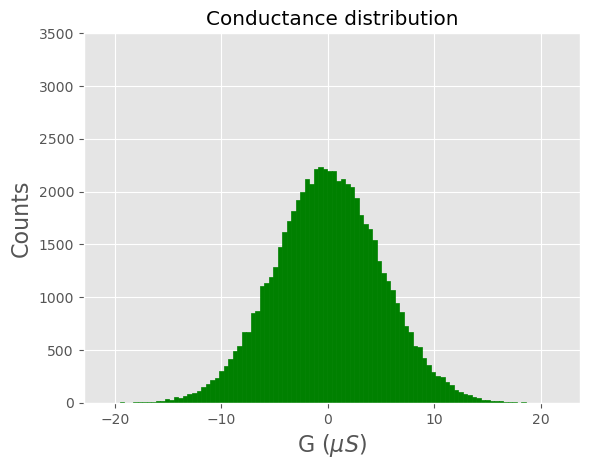

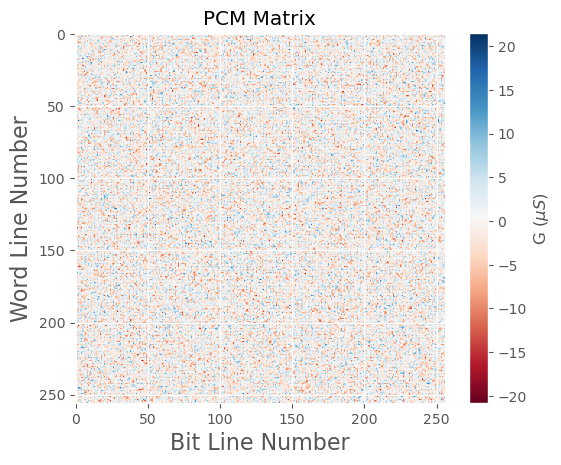

In [5]:
PAR_NumWL = 256
PAR_NumBL = 256
PAR_NumPCM = PAR_NumWL*PAR_NumBL
PAR_GMax = 15
PAR_DistMean = 0
PAR_DistStd = PAR_GMax/3
PAR_MatrixRef = np.random.normal(PAR_DistMean, PAR_DistStd, PAR_NumPCM)


fig = plt.subplots()
plt.title("Conductance distribution")
plt.hist(PAR_MatrixRef,bins=100,edgecolor="green", color="green")
plt.xlabel('G ($\mu S$)', fontsize=16)
plt.ylabel('Counts', fontsize=16)
plt.ylim([0, 3500])

fig = plt.subplots()
plt.title("PCM Matrix")
PAR_MatrixRef2D= PAR_MatrixRef.reshape(PAR_NumWL,PAR_NumWL)
plt.imshow(PAR_MatrixRef2D,cmap='RdBu')
plt.colorbar(label='G ($\mu S$)')
plt.xlabel('Bit Line Number', fontsize=16)
plt.ylabel('Word Line Number', fontsize=16)

Lines 1-5 defines the matrix size (word and bit lines), matrix's conductance mean, matrix's conductance standard deviation
<br>
Lines 6 initializes the matrix elements with a Gaussian (normal) distributed conductance values
<br>
Lines 9-14 creates a histogram plot of the matrix
<br>
Lines 16-22 creates a 2D plot of the matrix
<br>
<br>
We refer to this conductance distribution as ideal. It is free from any non-indeality and is therefore our reference distribution
<br>
"In the following we will see how each non-indeality individually alter this ideal matrix"

### Step 1.1: We inject the non-ideality of resistance drift into all conductance states
<br>
Definition: 'When amorphous, the disordered atomic structure of the phase-change material relaxes towards the lower energy states in time. This process is manifested in the embodiment of a time-dependent decrease in conductance. In doped PCMs we also observe resistance drift in the crystalline state, likely a result of the relaxations in excess amorphous like grain boundaries.'
<br>
<br>
Mathematically drift follows a power law relation $G_{i,j}=G_{0_{i,j}}\times (\frac{t}{t_{0}})^{-\nu}$, where $\nu$ is drift coefficient, t is elapsed time after programming and G is conductance. 
<br>
<br>
To simulate resistance drift we first have to define the state-dependent (conductance) mean and standard deviation of $\nu$. Each PCM element of unique conductance value in the matrix gets altered distinctly owing to this state dependency. We extract the state dependency using mathematical functions that was fitted experimental data  

(0.0, 3500.0)

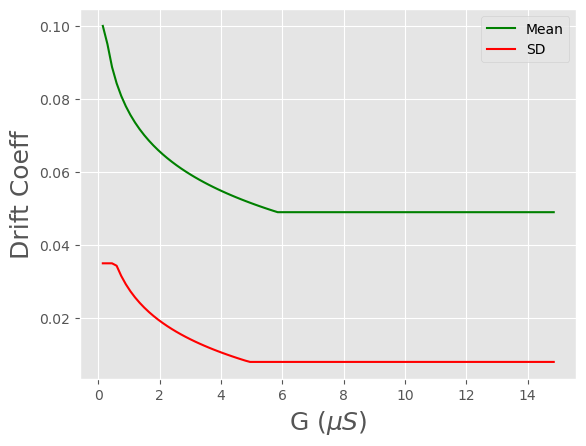

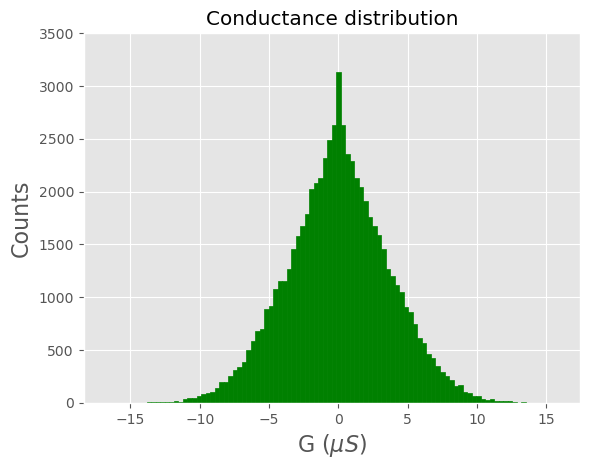

In [6]:
# Get state dependent mean and standard deviation of drift coefficients
PAR_DriftMean=[]
PAR_DriftStd=[]
x=np.arange(0.01,1,0.01)
PAR_G = x*PAR_GMax

def f(x):
    for i in range(0,len(x)):
        DUM_A= min(np.append(max(np.append(-0.0155*np.log(x[i])+0.0344,0.049)),0.1))
        DUM_B= min(np.append(max(np.append(-0.0125*np.log(x[i])-0.0059,0.008)),0.035))
        PAR_DriftMean.append(DUM_A)
        PAR_DriftStd.append(DUM_B)

PAR_D=f(x)
fig = plt.subplots()
#plt.title('State dependent drift coeff')
plt.plot(PAR_G,PAR_DriftMean,color="green",label='Mean')
plt.plot(PAR_G,PAR_DriftStd,color="Red",label='SD')
plt.xlabel('G ($\mu S$)', fontsize=18)
plt.ylabel('Drift Coeff', fontsize=18)
leg = plt.legend();

# Modify the reference matrix conductance values using the drift coefficients
PAR_t = 500
PAR_MatrixRD2D=np.zeros((256,256))
for i in range(0,PAR_NumWL):
    for j in range(0,PAR_NumWL):
        DUM_C=PAR_MatrixRef2D[i][j]
        DUM_DIndex= np.argmin(abs(abs(DUM_C)-PAR_G))
        DUM_Factor= PAR_DriftMean[DUM_DIndex]+PAR_DriftStd[DUM_DIndex]*np.random.normal(0, 1, 1);
        PAR_MatrixRD2D[i][j]= DUM_C*(PAR_t**-DUM_Factor)

PAR_MatrixRD=PAR_MatrixRD2D.reshape(256*256)
fig= plt.subplots()
plt.title("Conductance distribution")
plt.hist(PAR_MatrixRD,bins=100,edgecolor="green", color="green")
plt.xlabel('G ($\mu S$)', fontsize=16)
plt.ylabel('Counts', fontsize=16)
plt.ylim([0, 3500])


Lines 2-5 initialzes variables 
<br>
Lines 7-12 is a function that establishes the relationship between G and Drift 
<br>
Lines 14-21 creates a plot of the G and Drift relationship
<br>
Lines 24-31 initialzes variables 
<br>
Lines 25-30 associates a mean and a drift coefficient with every element in our reference conductance matrix
<br>
Lines 33-39 creates a histogram plot

### Step 1.2: We inject the non-ideality of READ noise into all conductance states

Definition: 'These are conductance fluctuations that are characterized by a power spectral density that scales inversely with the frequency. The mechanism that leads to READ noise is still debated, however, a few models propose the concept of a bi-stable configuration where the atoms or electrons can reversibly toggle'
<br>
Mathematically read noise follows $\sigma_{i,j}=G_{i,j}\times Q_{s}\sqrt{log(\frac{fmax}{fmin}})$, where Q is some constant dependent of G and f$_{max/min}$ is the frequency window. READ noise is equivalent to the standard deviation of a conductance time-series signal.
<br>
<br>
For further reading, refer to [IEEE International Conference on Electronics, Circuits and Systems (ICECS), 2019, pp. 727-730](10.1109/ICECS46596.2019.8964852) 

(0.0, 3500.0)

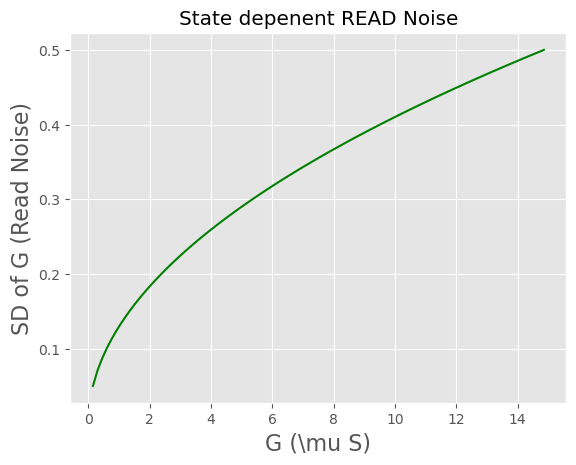

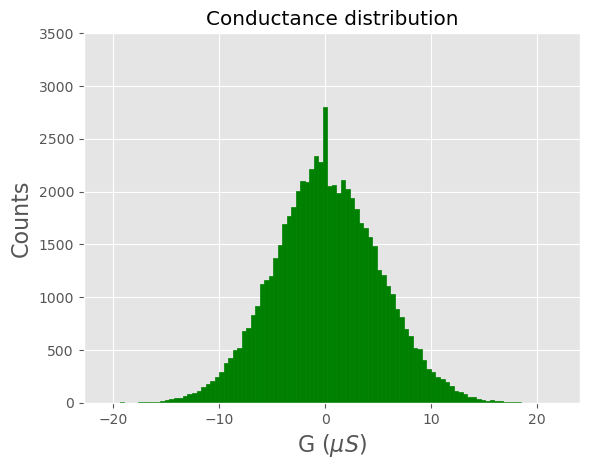

In [7]:
# Get state dependent standard deviation/READ noise
PAR_READStd=[]
PAR_f_integral = np.sqrt(np.log((1+250e-9)/(2*250e-9)));

def f(x):
    for i in range(0,len(x)):
        DUM_Qs_f= min(np.append(0.0088/x[i]**0.5,2e-1))
        DUM_A = PAR_G[i]*DUM_Qs_f*PAR_f_integral;
        PAR_READStd.append(DUM_A)

PAR_D=f(x)
fig = plt.subplots()
plt.title('State depenent READ Noise')
plt.plot(PAR_G,PAR_READStd,color="green")
plt.xlabel('G (\mu S)',fontsize=16)
plt.ylabel('SD of G (Read Noise)',fontsize=16)

# MAC with Read noise
PAR_MatrixRead2D=np.zeros((PAR_NumWL,PAR_NumWL))
for i in np.arange(1,PAR_NumWL):
    for j in np.arange(1,PAR_NumWL):
        DUM_A = PAR_MatrixRef2D[i,j]
        DUM_B=np.argmin(np.abs(np.abs(DUM_A)-PAR_G))
        Factor = PAR_READStd[DUM_B]
        PAR_MatrixRead2D[i,j]= DUM_A+Factor*np.random.uniform(0,1,1)

PAR_MatrixRead=PAR_MatrixRead2D.reshape(PAR_NumPCM)
fig = plt.subplots()
plt.title("Conductance distribution")
plt.hist(PAR_MatrixRead,bins=100,edgecolor="green", color="green")
plt.xlabel('G ($\mu S$)', fontsize=16)
plt.ylabel('Counts', fontsize=16)
plt.ylim([0, 3500])


Lines 2-3 initialzes variables 
<br>
Lines 5-9 is a function that establishes the relationship between G and Read noise
<br>
Lines 11-15 creates a plot of the G and Read noise relationship
<br>
Lines 19-25 associates a read noise to every matrix element in the reference array
<br>
Lines 27-33 plots the histogram of the noisy weights

### Step 1.3: We inject the non-ideality of temperature sensitivity into all conductance states

Definition: 'Because phase-change materials are typically low-band gap semiconductors, the thermally activated nature of electrical transport implies the device's conductance becomes sensitive to the ambient temperature. Increase in ambient temperature results in decrease of conductance and vice versa'
<br>
<br>
Mathematically temperature sensitivity follows the relation $G_{i,j}= G_{0}\times \exp^{\frac{-E_a}{kT}}$, where $E_a$ is activation energy for thermal transport, k is Boltzmann constant and T is the temperature. To simulate the temperature sensitivity, we have to define the state-depenedent (conductance) mean and standard deviation of $E_a$.
<br>
<br>
For further reading, refer to [IEEE International Electron Devices Meeting (IEDM), 2021, pp- 28-3](https://ieeexplore.ieee.org/abstract/document/9720519) 

(0.0, 3500.0)

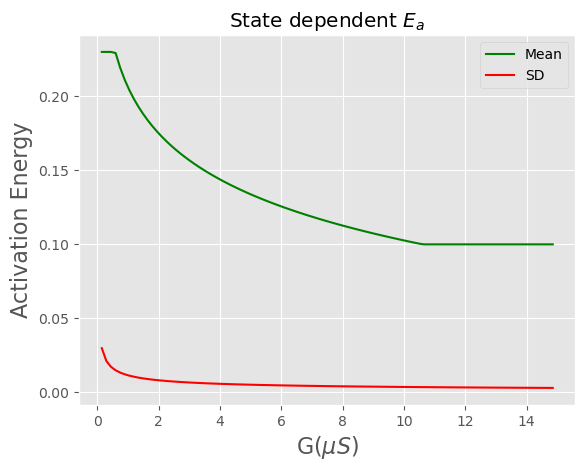

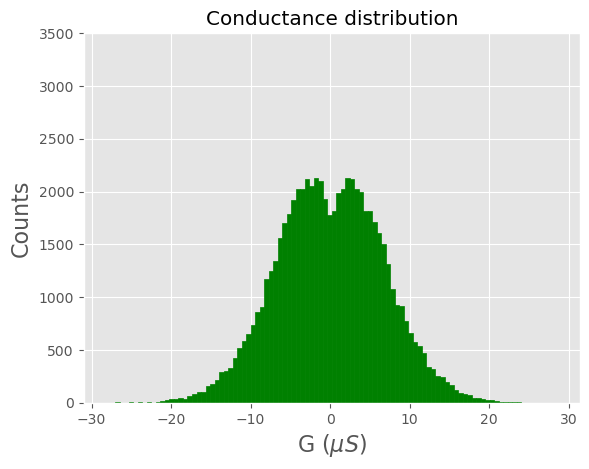

In [8]:
# Get state dependent mean and standard deviation of Activation Energy
PAR_TempMean=[]
PAR_TempStd=np.true_divide((PAR_GMax*0.0001),PAR_READStd)

def f(x):
    for i in range(0,len(x)):
        DUM_A= min(np.append(max(np.append(-0.045*np.log(x[i])+0.0844,0.10)),0.23))
        PAR_TempMean.append(DUM_A)

PAR_D=f(x)
fig = plt.subplots()
plt.title('State dependent $E_{a}$')
plt.plot(PAR_G,PAR_TempMean,color="green",label="Mean")
plt.plot(PAR_G,PAR_TempStd,color="red",label="SD")
plt.xlabel('G($\mu S$)', fontsize=16)
plt.ylabel('Activation Energy', fontsize=16)
leg = plt.legend();

# Modify the reference matrix conductance values using the Activation Energies
PAR_T=350;
PAR_MatrixTS2D=np.zeros((PAR_NumWL,PAR_NumWL))
for i in range(0,PAR_NumWL):
    for j in range(0,PAR_NumWL):
        DUM_C=PAR_MatrixRef2D[i][j]
        DUM_DIndex= np.argmin(abs(abs(DUM_C)-PAR_G))
        DUM_Factor= PAR_DriftMean[DUM_DIndex]+PAR_DriftStd[DUM_DIndex]*np.random.normal(0, 1, 1);
        DUM_E= np.divide(DUM_C,np.exp(-DUM_Factor/(8.6e-5*300)))
        PAR_MatrixTS2D[i][j]= DUM_E*np.exp(-DUM_Factor/(8.6e-5*PAR_T))

PAR_MatrixTS=PAR_MatrixTS2D.reshape(PAR_NumPCM)
fig = plt.subplots()
plt.title("Conductance distribution")
plt.hist(PAR_MatrixTS,bins=100,edgecolor="green", color="green")
plt.xlabel('G ($\mu S$)', fontsize=16)
plt.ylabel('Counts', fontsize=16)
plt.ylim([0, 3500])


Lines 2-3 initialzes variables. Line 3 approximates the relationship between G and standard deviation of $E_{a}$
<br>
Lines 5-8 is a function that establishes the relationship between G and mean of $E_{a}$
<br>
Lines 10-17 creates a plot of the G and bipolar asymmetry relationship
<br>
Lines 20-21 initialzes variables. PAR_T is ambient temperature 
<br>
Lines 22-28 associates an  $E_{a}$ with every element in our reference conductance matrix
<br>
Lines 30-36 creates a histogram plot of the temperature influenced matrix elements

###  Step 1.4: We inject the non-ideality of bi-polar asymmetry into all conductance states

Definition: 'When phase-change materials make contact with metallic electrodes, interfacial barriers can form, the size of which is dictated by both phase-change materials and electrode properties (work functions). If the barriers at the interfaces with the bottom electrode and top electrode were to differ, the current flow becomes polarity dependent'.
<br>
<br>
Mathematically bipolar asymmetry follows the relation $\alpha_{i,j}= \frac{I_{i,j (pos)}}{I_{i,j(neg)}}$, where the current under a positive polarity read signal differs from the negative polarity read signal by some factor $\alpha$. To simulate bipolar asymmetry, we first have to define the state-dependent (conductance) mean and standard deviation of $\alpha$.
<br>
<br>
For further reading refer to [Adv. Mater. 2022, 2201238](https://doi.org/10.1002/adma.202201238)

(0.0, 3500.0)

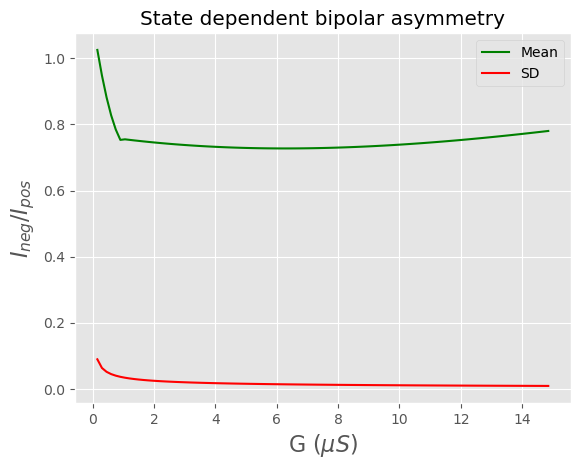

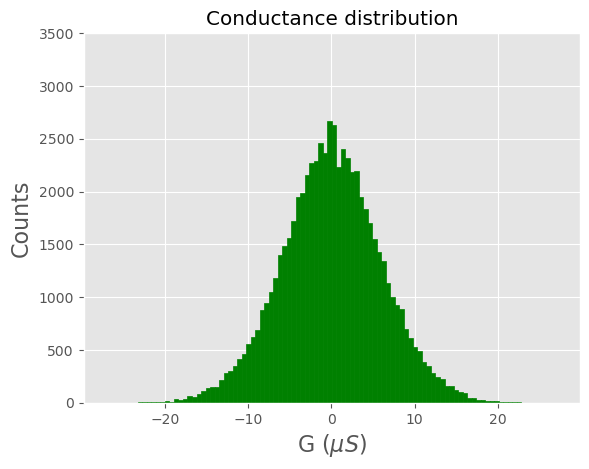

In [9]:
# Get state dependent mean and standard deviation of α
x=np.arange(0.01,1,0.01)
PAR_BPMean=[]
PAR_BPStd=np.true_divide((PAR_GMax*0.0003),PAR_READStd)

def f(x):
    for i in range(0,len(x)):
        if i<6:
            DUM_A= np.polyval(np.poly1d([0.2555, -0.6312, 1.1144]),PAR_G[i])
        elif i>5:
            DUM_A= np.polyval(np.poly1d([-2.1240e-05, 0.0013, -0.0138, 0.7681]),PAR_G[i])
        PAR_BPMean.append(DUM_A)

PAR_D=f(x)
fig = plt.subplots()
plt.title('State dependent bipolar asymmetry')
plt.plot(PAR_G,PAR_BPMean,color="green",label='Mean')
plt.plot(PAR_G,PAR_BPStd,color="red",label='SD')
plt.xlabel('G ($\mu S$)', fontsize=16)
plt.ylabel('$I_{neg}/I_{pos}$', fontsize=16)
leg = plt.legend();

# Modify the conductance reference matrix using α
PAR_IN=np.concatenate([0.2*np.array(np.ones(128)),-0.2*np.array(np.ones(128))])
# Shuffle the Inputs
np.random.shuffle(PAR_IN)
PAR_MatrixBP2D=np.zeros((PAR_NumWL,PAR_NumWL))
for i in range(0,len(PAR_IN)):
    if PAR_IN[i]<0:
        for j in range(0,len(PAR_IN)):
            DUM_C=PAR_MatrixRef2D[j][i]
            DUM_DIndex= np.argmin(abs(abs(DUM_C)-PAR_G))
            DUM_Factor= PAR_BPMean[DUM_DIndex]+(PAR_BPStd[DUM_DIndex]*np.random.normal(0, 1, 1));
            PAR_MatrixBP2D[j][i]= DUM_C*np.divide(1,DUM_Factor)
    else:
        PAR_MatrixBP2D[:,i]=PAR_MatrixRef2D[:,i]

fig = plt.subplots()
plt.title('Conductance distribution')
PAR_MatrixBP=PAR_MatrixBP2D.reshape(PAR_NumPCM)
plt.hist(PAR_MatrixBP,bins=100,edgecolor="green",color="green")
plt.xlabel('G ($\mu S$)', fontsize=16)
plt.ylabel('Counts', fontsize=16)
plt.ylim([0,3500])

Lines 2-4 initializes variables. Line 3 approximates the relationship between G and standard deviation of $\alpha$
<br>
Lines 6-12 describe a function that establishes the relationship between G and mean of $\alpha$
<br>
Lines 14-21 creates a plot of the G and bipolar asymmetry relationship
<br>
Lines 24-27 creates an input vector that has randomly placed + and - 0.2 V read signal
<br>
Lines 28-36 associates a mean and DD drift coefficient with every element in our reference conductance matrix
<br>
Lines 38-40 creates a histogram plot of the bi-polar asymmetry influenced matrix elements

###   Step 2: Now that we have seen the different non-idealities and their state dependence, it is time we see how they contribute to the computational imprecisions 

To do this we perfrom matrix vector operations (MAC) with our 256 by 256 crossbar, first without non-idealities and then introducing the non-idealities one by one. We then compare the with and without currents using a normalized MAC error ($\frac{||\text{I}-\bar{\text{I}}||}{||\text{I}||}$, where $I$ is net current on columns of the crossbar without non-idealities, and $\bar{I}$ is with non-idealities. We want the MAC error to be small.

(0.0, 0.35)

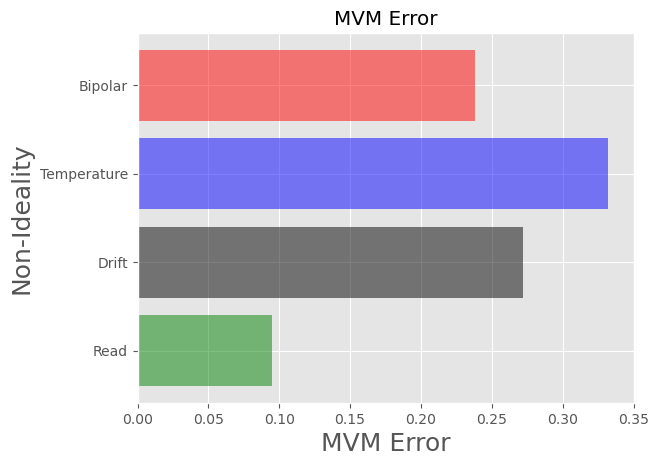

In [10]:
## Intitialize an Input Vector. Each element in the vector can be +200 mV or -200 mV

# MAC without non-idealities
MAC_I= np.dot(PAR_MatrixRef2D,PAR_IN)

# MAC with READ noise
MAC_IbarRead= np.dot(PAR_MatrixRead2D,PAR_IN)

# MAC with Resistance Drift
MAC_IbarRD= np.dot(PAR_MatrixRD2D,PAR_IN)

# MAC with Temperature Fluctuations
MAC_IbarTemp= np.dot(PAR_MatrixTS2D,PAR_IN)

# MAC with Bipolar Noise
MAC_IbarBP= np.dot(PAR_MatrixBP2D,PAR_IN)


## Lets estimate the errors and plot them
RelNormError_Read = np.divide(np.linalg.norm(MAC_I-MAC_IbarRead),np.linalg.norm(MAC_I))
RelNormError_Drift = np.divide(np.linalg.norm(MAC_I-MAC_IbarRD),np.linalg.norm(MAC_I))
RelNormError_Temp = np.divide(np.linalg.norm(MAC_I-MAC_IbarTemp),np.linalg.norm(MAC_I))
RelNormError_BP = np.divide(np.linalg.norm(MAC_I-MAC_IbarBP),np.linalg.norm(MAC_I))

fig = plt.subplots()
plt.title('MVM Error')
x = ['Read','Drift', 'Temperature', 'Bipolar']
y= [RelNormError_Read,RelNormError_Drift,RelNormError_Temp,RelNormError_BP]
plt.barh(x,y,color=['green','black','blue','red'],alpha=0.5)
plt.xlabel('MVM Error', fontsize=18)
plt.ylabel('Non-Ideality', fontsize=18)
plt.xlim([0, 0.35])


Lines 3-16 are the dot product bewteen the input vector and the matrix without and with non-idealities. The output is a vector whose each element represents the accumulted current on every column
<br>
Lines 20-23 computes the normalized MAC error under different non-idealities 
<br>
Lines 25-30 creates a bar chat plot skteching the different MAC error for different non-idealites


###   Step 3: We want these non-idealities to minimally affect our computational operations. There are software tricks we could use to realize this. 

One such is the global compensation scheme. In this scheme, we correct for the output currents on the bit lines using a correction factor ($\beta$). The correction factor is estimated by comparing the MAC operations at a given time instance ($I(t,T)$) against a reference MAC operation ($I_{REF}$); such that $\beta=\frac{I_{REF}}{I(t,T)}$. Under resistance drift, the currents decrease with time, thus by using $\beta\times I(t,T)$ we can compensate for drift. Similar corrections can be used for correcting the ambient temperature fluctuations. We commonly refer to these schemes as GDC (global drift corrections). 

Such approaches, however, are inadequate for bipolar asymmetry corrections. This is because the non-ideality does not change in time, instead has an unfavorable input dependency. We can however compensate for the non-ideality by changing the amplitude of the input read voltages. The main idea lies in the fact that the one type of bias polarity (-ve in this case), can be adjusted relative to the other such that the currents produced by either are similar ($\text{I}\!\simeq \!\bar{\text{I}}$). Here, $V_{\text{-ve}}=\beta\times V_{\text{+ve}}$, where $\beta$ is estimated using hardware in the loop.

Note that while the software schemes can be used, an ideal approach would be making physical devices that should these non-idealities, minimally. One such is the projected memory devices (see [Adv. Funct. Mater. 2021, 31, 2106547](https://doi.org/10.1002/adfm.202106547), [Nature Communications. 2015 6, 8181](https://www.nature.com/articles/ncomms9181))

(0.0, 0.35)

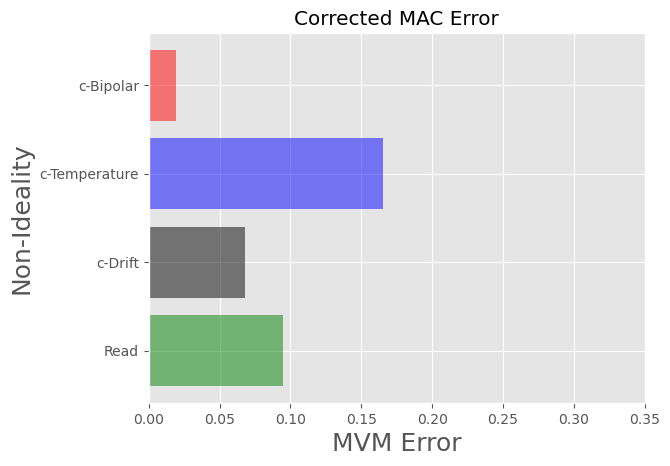

In [11]:
# GDC for Temperature fluctuation correction
PAR_FactoTS= np.divide(np.sum([MAC_I[1:20]]),np.sum([MAC_IbarTemp[1:20]]))
MAC_ITSCorr = PAR_FactoTS*MAC_IbarTemp

# GDC for Resistance drift correction
PAR_IFactoRD= np.divide(np.sum([MAC_I[1:20]]),np.sum([MAC_IbarRD[1:20]]))
MAC_IRDCorr = PAR_IFactoRD*MAC_IbarRD

# Bipolar asymmetry corrections
PAR_FactoBPCorr=-0.1474
PAR_INc=PAR_IN
for n, i in enumerate(PAR_INc):
    if i < 0:
        PAR_INc[n] = PAR_FactoBPCorr
MAC_IBPCorr = np.dot(PAR_MatrixBP2D,PAR_INc)

## Lets estimate the errors and plot them
RelNormError_Read = np.divide(np.linalg.norm(MAC_I-MAC_IbarRead),np.linalg.norm(MAC_I))
RelNormError_Drift = np.divide(np.linalg.norm(MAC_I-MAC_IRDCorr),np.linalg.norm(MAC_I))
RelNormError_Temp = np.divide(np.linalg.norm(MAC_I-MAC_ITSCorr),np.linalg.norm(MAC_I))
RelNormError_BP = np.divide(np.linalg.norm(MAC_I-MAC_IBPCorr),np.linalg.norm(MAC_I))

fig = plt.subplots()
plt.title('Corrected MAC Error')
x = ['Read','c-Drift', 'c-Temperature', 'c-Bipolar']
y= [RelNormError_Read,RelNormError_Drift,RelNormError_Temp,RelNormError_BP]
plt.barh(x,y,color=['green','black','blue','red'],alpha=0.5)
plt.xlabel('MVM Error', fontsize=18)
plt.ylabel('Non-Ideality', fontsize=18)
plt.xlim([0, 0.35])

Lines 1-3 computes the matrix elements for corrected (using GDC) temperature non-ideality
<br>
Lines 6-7 computes the matrix elements error for corrected (using GDC) resistance drift non-ideality
<br>
Lines 9-15 computes the matrix elements error for corrected (read voltage modulation) bi-polar asymmetry non-ideality
<br>
Lines 18-21 computes the normalized MAC error under different non-idealities 
<br>
Lines 23-28 creates a bar chat plot skteching the different MAC error for different non-idealites

### Buidng AIHWKit library functions for non-idealities
<br>
If you made it so far, kudos to you for keeping up!
<br>
<br>
In the above, we defined the various non-idealities using user defined equations.  These equations, however, can be casted into library functions and used in various DNN models.
<br><br>
As a first step create a class comprising definations for various non-idealities, for example as below

In [12]:
from aihwkit.inference.noise.pcm import PCMLikeNoiseModel

class MyPCMNoiseModel(PCMLikeNoiseModel):
    def generate_drift_coefficients(self, G_target, t_inference):
        # define drift coefficients coefficients
    def apply_programming_noise_to_conductance(self, G_target):
         # define programming noise

IndentationError: expected an indented block after function definition on line 4 (2419996648.py, line 6)

a device specification can be then called using the constructor, as shown below

In [ ]:
my_noise  =  MyPCMNoiseModel()
noise_weights = my_noise.generate_drift_coefficients(G_target = weight, t_inference=3600.0)

or use that directly to generate tiles / or modules e.g.

In [ ]:
from aihwkit.simulator.tiles.inference import InferenceTile
from aihwkit.simulator.config import InferenceRPUConfig

rpu_config = InferenceRPUConfig(noise_model=MyPCMNoiseModel())
analog_tile = InferenceTile(50, 50, rpu_config=rpu_config)
analog_tile.set_weights(randn(50,50))
analog_tile.program_weights()   # applied noise model
analog_tile.forward(x)  # forward pass with applied programming noise + other non-idealities

Or just using a linear module instead of an InferenceTile (a module could have multiple tiles):

In [ ]:
from aihwkit.nn import AnalogLinear

rpu_config = InferenceRPUConfig(noise_model=MyPCMNoiseModel())
linear = AnalogLinear(50, 50, rpu_config=rpu_config)
linear.drift_analog_weights(t_inference=100.0)
y = linear(x)